# Moodify

Song Recommendation based on Users’ Emotion Recognition System.

In [1]:
import os
import numpy as np
import tensorflow as tf
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
print("Using GPU:", tf.config.list_physical_devices("GPU"))

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

train_dir = "data/train"
test_dir  = "data/test"

assert os.path.isdir(train_dir), "train_dir not found – check the path/ls output"
assert os.path.isdir(test_dir),  "test_dir not found – check the path/ls output"

# Set up

In [4]:
size = 48
batch_size = 32
num_classes = 4
input_shape = (size, size, 1)

train_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4]
)


train_set = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_set = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_data_generator = ImageDataGenerator(rescale=1./255)

test_set = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Class indices:", train_set.class_indices)

Found 18906 images belonging to 4 classes.
Found 2099 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [5]:
def create_model_predict_emotion(num_classes=4):

    model = tf.keras.Sequential([

        # 64 filters
        layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal', input_shape=(48,48,1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # 128 filters
        layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # 256 filters
        layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Softmax (4 classes)
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),  # LR tuned for stability
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model


In [6]:
def plot_model(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train vs Val Accuracy')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Val Loss')

    plt.tight_layout()
    plt.show()

In [7]:
def accuracy_on_test_set(model):
    test_loss, test_acc = model.evaluate(test_set)
    print(f"Test accuracy: {test_acc:.2f}")
    print(f"Test loss: {test_loss:.2f}")

In [8]:
def fit_and_save_model(path="best_model.h5"):
    # Create and show model
    model = create_model_predict_emotion()
    model.summary()

    epochs = 60
    checkpoint_path = path

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Callback list
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
        lr_scheduler
    ]

    # Training
    history = model.fit(
        train_set,
        validation_data=val_set,
        epochs=epochs,
        callbacks=callbacks
    )

    # Visualization
    plot_model(history)

    # Test accuracy
    accuracy_on_test_set(model)

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

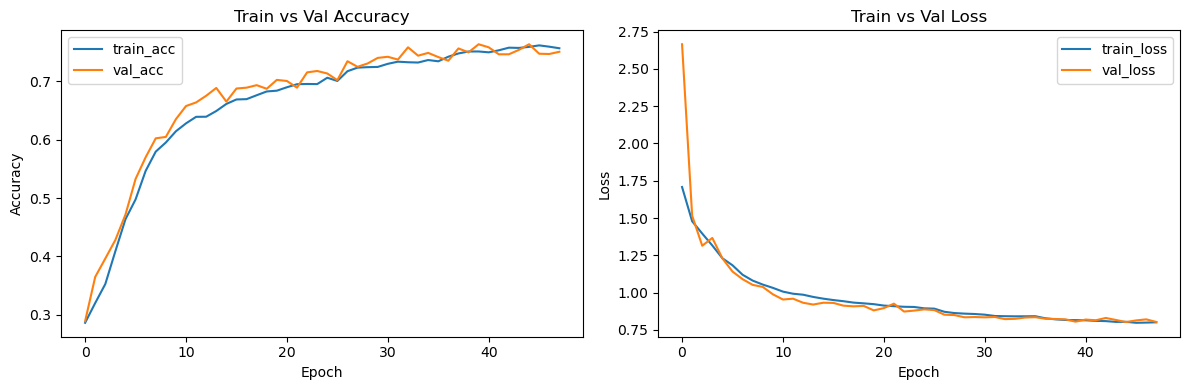

163/163 [==============================] - 7s 41ms/step - loss: 0.8271 - accuracy: 0.7439
Test accuracy: 0.74
Test loss: 0.83


In [9]:
fit_and_save_model()

In [10]:
emotion_labels = ["Angry", "Sad", "Happy", "Neutral"]

def process_img(img_path):
    img = load_img(img_path, color_mode='grayscale', target_size=(size, size))
    x = img_to_array(img).astype("float32") / 255.0
    x = np.expand_dims(x, axis=0)
    return x

def upload_predict_and_save(model, mood_txt_path="current_mood.txt"):
    print("Select an image file of your face.")

    root = tk.Tk()
    root.withdraw()

    img_path = filedialog.askopenfilename(
        filetypes=[("Image files", "*.jpg *.jpeg *.png")]
    )

    if not img_path:
        print("No file selected.")
        return

    probs = model.predict(process_img(img_path))
    emotion = emotion_labels[int(np.argmax(probs))]

    with open(mood_txt_path, "w") as f:
        f.write(emotion + "\n")

    print(f"Predicted emotion: {emotion}")


In [12]:
model = load_model("best_model.h5")
upload_predict_and_save(model)

Select an image file of your face.
1/1 [==============================] - 1s 669ms/step
Predicted emotion: Angry
